# 2020-08-12 Why is DQN Better?
Try to find out why Big Ms are happening on Bestfit, and why DQN is better than best fit in the end

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = "retina"
from pathlib import Path
import os
from IPython.display import display, Markdown, Latex

project_dir = Path(globals()['_dh'][0]+"/../python").resolve()
os.chdir(project_dir)
print("Running notebook from: " + os.path.abspath(""))


from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "last_expr" # Default jupyter behavior
InteractiveShell.ast_node_interactivity = "all" # All expressions are shown.

Running notebook from: /Users/aleph/Documents/jota/tesis/ts_mcfrl/python


# 1 - See actions and Big Ms of ep 999

In [20]:
dqn2_actions_ep_999 = pd.read_csv("data/results/dqn2_few_warehouses_v3/ep_999/movement_detail_report.csv")
bestfit_actions_ep_999 = pd.read_csv("data/results/bestfit_few_warehouses_v3/ep_999/movement_detail_report.csv")

bestfit_consolidated_summary = pd.read_csv("data/results/bestfit_few_warehouses_v3/consolidated_summary.csv")
dqn2_consolidated_summary = pd.read_csv("data/results/dqn2_few_warehouses_v3/consolidated_summary.csv")

big_m = 100000
dqn2_actions_ep_999['is_m'] = dqn2_actions_ep_999.customer_cost == dqn2_actions_ep_999.customer_units*big_m*10
bestfit_actions_ep_999['is_m'] = bestfit_actions_ep_999.customer_cost == bestfit_actions_ep_999.customer_units*big_m*10

As seen below, in the last episode DQN achieved lower number of bigms and thus lower overall cost. I can't see what the parameters were for this run so I don't know  what the valid DCs were, but I can do a debug run to see why Bestfit does BigM sometimes.

In [19]:
print("DQN Big Ms")
dqn2_actions_ep_999.groupby('is_m').size()
print("Bestfit Big Ms")
bestfit_actions_ep_999.groupby('is_m').size()

print("Total cost ep 999 dqn")
dqn2_consolidated_summary.query('episode==999').total_cost.sum()
print("Total cost ep 999 bestfit")
bestfit_consolidated_summary.query('episode==999').total_cost.sum()


DQN Big Ms


is_m
False    650
True      78
dtype: int64

Bestfit Big Ms


is_m
False    650
True      99
dtype: int64

Total cost ep 999 dqn


1979889830

Total cost ep 999 bestfit


3280709290

# 2- Debugging Bestfit

Bestfit is choosing DC 0, but some inventory is flowing from the other legal  DC, with Big M cost (because two DCs are being used?) 
Why are two dcs being used, could be that inventory is depleted.
```
Allowed DCs: [0 2]
Chose allowed DC: -55 0
Bestfit chose the legal move 0
This is a Big M cost found in the optimization 14__dcs_2^0:5=>560__oc_66:5^0:5 ==> 3816

```

Looks like extended network, around line 119-125, is skipping all nodes of that c_66. Possibly because it's not in location_time_nodemap? 
Test those conditions very carefully. In the end, that arc is as if it didn't exist even though it's a valid arc. The NN learns to avoid this DC as it is bugged,
But the bestfit may fall onto it again and again.

This is funnily an advantage of the NN: it realized the bug before we did.

I'm too tired to debug that condition, so Im gona do an agent that only chooses that Dcto validate.

Looks like my theory is right: the TOP most valid DC is actually illegal in the extended network. Try testing it with a small net.

On smaller envs happens after a while

In [28]:
#plot ep costs for review
d_summary_high = pd.read_csv("/Users/aleph/Documents/jota/tesis/ts_mcfrl/python/data/results/z_debug_agent_highest/ep_0/summary_movement_report.csv").reset_index()
d_summary_bestfit = pd.read_csv("/Users/aleph/Documents/jota/tesis/ts_mcfrl/python/data/results/z_debug_bestfit_few_warehouses/ep_0/summary_movement_report.csv").reset_index()

No handles with labels found to put in legend.


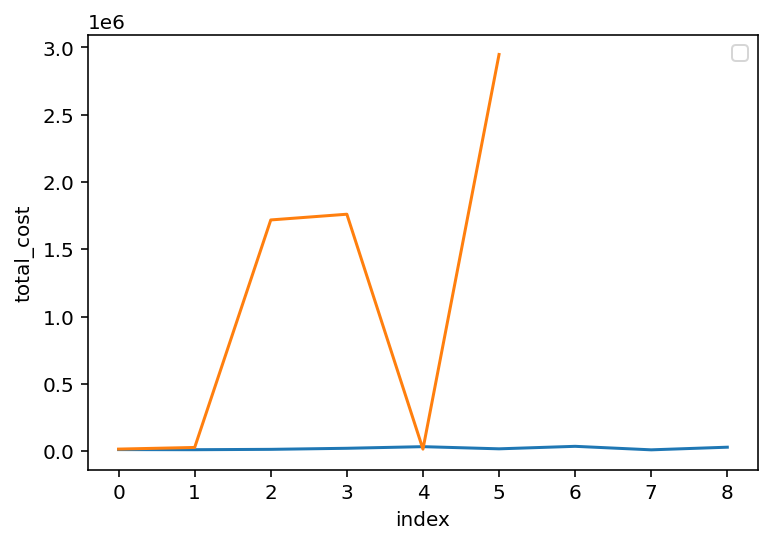

In [36]:
fig = plt.figure()
ax = sns.lineplot(x='index',y='total_cost',data=d_summary_high)
ax.set_label("A")
sns.lineplot(x='index',y='total_cost',data=d_summary_bestfit).set_label("B")
plt.legend()# i am tired. i am going to sleep.bye.